# Выпускной проект "Игры — Анализ рекламных источников"

Ссылка на презентацию https://disk.yandex.ru/i/bwS3gmCp3Uxx7Q

Ссылка на дашборд https://public.tableau.com/views/-_16860885274970/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link

### План проекта:
#### Введение
#### Обзор данных
#### Предобработка данных
1. Поиск и избавление от дубликатов
2. Приведение данных к нужным типам
3. Анализ причин пропущенных значений (обработка, замена)

#### Исследовательский анализ
1. Анализ количества построек на пользователя
2. Анализ среднего времени, которое пользователи проводят в игре 
3. Анализ доли пользователей завершивших уровень
4. Анализ долей различных стратегий в канале

#### Проверка гипотез

H0 - время завершения уровня не различается в зависимости способа прохождения, H1 - время завершения уровня различается в зависимости способа прохождения
    
H0 -Среднее время в игре пользователей из источника instagram_new_adverts равно среднему времени в игре пользователей из источника youtube_channel_reklama,
H1 - Среднее время в игре пользователей из источника instagram_new_adverts отличается от среднего времени в игре пользователей из источника youtube_channel_reklama

#### Расчет метрик
1. Стоимость привлечения пользователя (CAC)

#### Вывод

### Я - аналитик компании "Космические братья". Заказчик - отдел маркетинга игры "Космические братья".

### Цель: выявить проблемы в прошлой маркетинговой кампании и улучшить показатели, проанализировать канал привлечения и выявить лучшую стратегию.

### В моем распоряжении 3 датасета, которые предоставила компания. Предстоит обработать данные, провести анализ, проверить 2 гипотезы и рассчитать метрику.

# 1. Предобработка данных

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats as st
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')


<div class="alert alert-danger">
    <p><b>Комментарий тимлида: </b></p>
        
Далее код не отрабатывает. На сервере данные находятся в директории `/datasets/`. Для удобства советую посмотреть конструкцию `try-except` или метод `os.path.exist`
<div class="alert alert-success">
    <p><b>Комментарий тимлида v2: </b>👍</p>
</div>
</div>

In [2]:
# загрузка фаилов

game_actions = pd.read_csv('/datasets/game_actions.csv')
ad_costs = pd.read_csv('/datasets/ad_costs.csv')
user_source = pd.read_csv('/datasets/user_source.csv')

### Датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

In [3]:
game_actions.head()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


In [4]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


In [5]:
# приводим столбец к нужному типу данных
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])

In [6]:
game_actions.isnull().sum()

event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

In [7]:
game_actions.duplicated().sum()

1

In [8]:
# удаляем явный дубликат
game_actions = game_actions.drop_duplicates().reset_index(drop=True)

In [9]:
game_actions['building_type'].unique()

array(['assembly_shop', 'spaceport', nan, 'research_center'], dtype=object)

In [10]:
game_actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

In [11]:
nan = game_actions[pd.isnull(game_actions['building_type'])]

In [12]:
nan.head()

,event_datetime,event,building_type,user_id,project_type
6659,2020-05-04 19:47:29,finished_stage_1,NaN,ced7b368-818f-48f6-9461-2346de0892c5,NaN
13134,2020-05-05 13:22:09,finished_stage_1,NaN,7ef7fc89-2779-46ea-b328-9e5035b83af5,NaN
15274,2020-05-05 18:54:37,finished_stage_1,NaN,70db22b3-c2f4-43bc-94ea-51c8d2904a29,NaN
16284,2020-05-05 21:27:29,finished_stage_1,NaN,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,NaN
19650,2020-05-06 06:02:22,finished_stage_1,NaN,58e077ba-feb1-4556-a5a0-d96bd04efa39,NaN


In [13]:
not_nan = nan[nan['project_type'] == 'satellite_orbital_assembly']

In [14]:
not_nan.head()

,event_datetime,event,building_type,user_id,project_type
47121,2020-05-08 18:10:25,project,NaN,e3c66498-9d45-4000-9392-f81e6796e7da,satellite_orbital_assembly
57398,2020-05-09 13:49:11,project,NaN,936e7af6-8338-4703-a1df-fc6c3f5b8e34,satellite_orbital_assembly
58797,2020-05-09 16:19:33,project,NaN,a4491c86-c498-4f74-a56e-65c136d0e9a1,satellite_orbital_assembly
61174,2020-05-09 20:29:01,project,NaN,85d9e675-562b-4329-8bbd-14d3b39096be,satellite_orbital_assembly
63770,2020-05-10 00:57:47,project,NaN,1889ca71-3c57-4e61-9ea6-a711971bbf0a,satellite_orbital_assembly


In [15]:
not_nan['event'].unique()

array(['project'], dtype=object)

In [16]:
game_actions[game_actions['building_type'].isna()]['event'].unique() 

array(['finished_stage_1', 'project'], dtype=object)

In [17]:
game_actions[game_actions['project_type'].isna()]['event'].unique() 

array(['building', 'finished_stage_1'], dtype=object)

Пропуски в строках - это пользователи, которые перешли на событие project. Это я выявила благодаря проверке, сделав выборки и посмотретла как связаны пропуски с типами. Никаких данных о постройках тут не должно быть потому что это факт события.

Мы убедились, что пропуски обусловлены механикой сбора данных и не являются ошибками. Если бы там были пропуски не в нужных местах, тогда надо было бы что-то делать. Сейчас можно удалить столбец, но я приняла решение его оставить.

### Датасет ad_costs.csv:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

In [18]:
ad_costs.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


In [19]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


In [20]:
# приводим к нужному типу данных
ad_costs['day'] = pd.to_datetime(ad_costs['day'])

In [21]:
ad_costs.duplicated().sum()

0

In [22]:
ad_costs['day'].min()

Timestamp('2020-05-03 00:00:00')

In [23]:
ad_costs['day'].max()

Timestamp('2020-05-09 00:00:00')

### Датасет user_source.csv

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

In [24]:
user_source.head()

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


In [25]:
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


In [26]:
user_source.duplicated().sum()

0

In [27]:
user_source['source'].unique()

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

Предобработка завершена. Удален дубликат, типы данных в столбцах event_datetime и day приведены к формату дата и время. Пропуски в данных удалять и заполнять не вижу смысла, так как в столбце building_type некоторые события не предполагают постройку, а пропуски в project_type означают невыполнение проекта. Данные подготовлены к анализу.

# 2. Исследовательский анализ

В данном разделе мы проанализируем пользовательское поведение.

In [28]:
# добавляем колонку с источником рекламы по идентификатору пользователя 
game_actions = game_actions.merge(user_source, how='left', on='user_id')

In [29]:
game_actions

,event_datetime,event,building_type,user_id,project_type,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,facebook_ads
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,yandex_direct
...,...,...,...,...,...,...
135634,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN,instagram_new_adverts
135635,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN,yandex_direct
135636,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN,youtube_channel_reklama
135637,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN,facebook_ads


In [30]:
game_user = game_actions.groupby(['user_id','event']).agg({'project_type' : 'nunique'}).reset_index()
game_user.columns = ['user_id','event', 'count']

In [31]:
game_user

,user_id,event,count
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,building,0
1,00151b4f-ba38-44a8-a650-d7cf130a0105,building,0
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,building,0
3,001d39dc-366c-4021-9604-6a3b9ff01e25,building,0
4,001d39dc-366c-4021-9604-6a3b9ff01e25,finished_stage_1,0
...,...,...,...
21254,fffb626c-5ab6-47c9-8113-2062a2f18494,finished_stage_1,0
21255,ffff194a-56b7-4c12-860d-3485242ae7f5,building,0
21256,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,building,0
21257,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,finished_stage_1,0


In [32]:
game_user_finish_project = list(game_user.query('event == "project" and count == 1')['user_id'])
len(game_user_finish_project)

1866

In [33]:
game_user_finish_victory = list(game_user.query('event == "finished_stage_1" and user_id not in @game_user_finish_project')['user_id'])
len(game_user_finish_victory)

3951

In [34]:
game_user_finish_project

['006380d6-67a6-45de-ab1e-6eb54ad8dbe8',
 '00be7371-fa79-4fbd-b8e7-8ba32e3f8f82',
 '00c2b9f2-2615-439c-aed0-6974e4c6c1c1',
 '00de2809-403e-4476-a2f7-ca1b11700190',
 '00e83261-5fd4-4939-9616-802b5a0202c6',
 '00fcac8c-cfae-420b-bffe-6eb797bbe460',
 '0108c741-3fa9-4027-af75-e642cac746ac',
 '0136963c-c45c-4edb-92d8-205bd50a4d36',
 '01766a0c-d9e3-41b5-b73c-a9c351cd616b',
 '018793d6-38c8-450a-bd54-8c181d920f1a',
 '01b39089-f0c8-43d8-813b-ab2680006806',
 '01cf532c-3944-4aaf-97c4-913d93025a39',
 '01d8ab1b-a7e1-475f-ae5b-d754ca9a1aaa',
 '01edfdf1-6854-45af-bc88-0dfb93f5617c',
 '02047f6e-aa8c-4046-88ae-5c7e3dbe9a89',
 '02054843-1e25-44a0-a54d-a93ef5c80cc6',
 '026ab851-761f-4b67-91de-5e3e3851d5f9',
 '0283c103-6572-4382-a7af-62390340eb24',
 '02ee9519-4b58-47b4-a006-85415e2d0564',
 '0318c26d-8c6d-4f5f-8ae0-828d1c7c887f',
 '0322b711-b7ef-434b-981c-afa1aa81bc60',
 '032557ae-ba95-4ab7-8298-50f9c89b8c00',
 '032b3ba1-7d71-43f6-b00b-8e1ce8970de5',
 '033364dc-f264-409c-b525-ad2c818723be',
 '03474cd6-7e84-

## 2.1. Анализ количества построек 

In [35]:
def building(df, name):
    user_build = df.groupby('user_id')['building_type'].count().reset_index()
    user_build.hist(bins=20, figsize=(12,5), color = 'green', ec = 'black');
    plt.title(f'Количество построек на пользователя', fontsize=15);
    plt.xlabel('Постройки', fontsize = 10) 
    plt.ylabel('Пользователи', fontsize = 10);
    print('Среднее количество построек: {:.1f}'.format(user_build['building_type'].sum() / user_build['user_id'].count()))

Среднее количество построек: 9.4


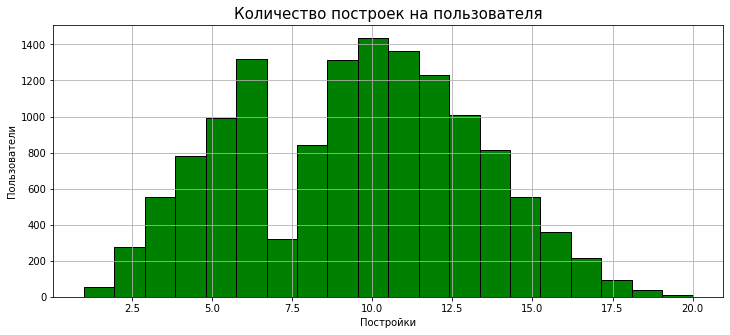

In [36]:
building(game_actions, 'all users')

Среднее число построек равно 9. На отметке 7-8 построек наблюдается спад, это может быть связано с тем, что на этой отметке пользователи переходят на новый уровень победив врага или продолжают постройку сданий дальше. Возможно, здесь так же есть игроки, которые еще в процессе прохождения уровня.

In [37]:
def buildings_per_source():
    buildings_per_source = game_actions.groupby('source')['building_type'].count().reset_index()
    plt.figure(figsize=(15,5))
    plt.title('Количество построек в зависимости от канала', fontsize = 15)
    sns.barplot(x = 'source', y = 'building_type', data = buildings_per_source)
    plt.xlabel('Канал', fontsize = 10) 
    plt.ylabel('Постройки', fontsize = 10)

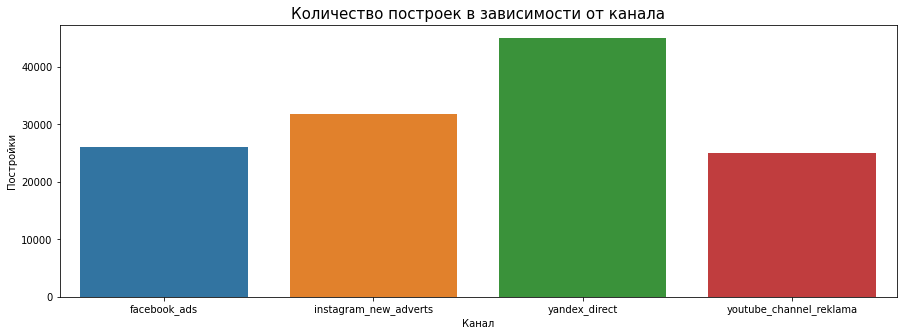

In [38]:
buildings_per_source()

In [39]:
youtube = game_actions[game_actions['source'] == 'youtube_channel_reklama'].reset_index(drop=True)
yandex = game_actions[game_actions['source'] == 'yandex_direct'].reset_index(drop=True)
facebook = game_actions[game_actions['source'] == 'facebook_ads'].reset_index(drop=True)
instagram = game_actions[game_actions['source'] == 'instagram_new_adverts'].reset_index(drop=True)

In [40]:
def building2(df, name):
    user_build = df.groupby('user_id')['building_type'].count().reset_index()
    user_build.hist(bins=20, figsize=(12,5), color = 'green', ec = 'black');
    plt.title(f'Количество построек на пользователя из источника Яндекс', fontsize=15);
    plt.xlabel('Постройки', fontsize = 10) 
    plt.ylabel('Пользователи', fontsize = 10);
    print('Среднее количество построек: {:.1f}'.format(user_build['building_type'].sum() / user_build['user_id'].count()))

Среднее количество построек: 9.3


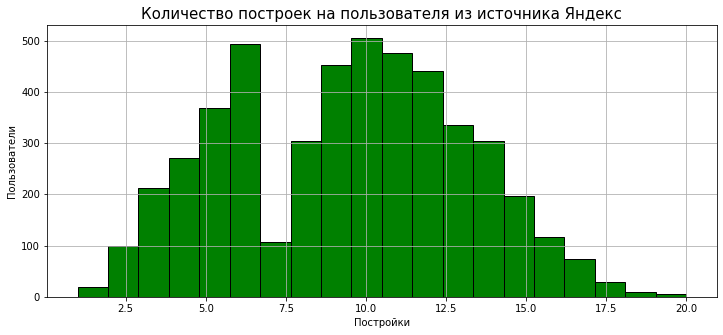

In [41]:
building2(yandex, 'yandex')

In [42]:
def building3(df, name):
    user_build = df.groupby('user_id')['building_type'].count().reset_index()
    user_build.hist(bins=20, figsize=(12,5), color = 'green', ec = 'black');
    plt.title(f'Количество построек на пользователя из источника Инстаграм', fontsize=15);
    plt.xlabel('Постройки', fontsize = 10) 
    plt.ylabel('Пользователи', fontsize = 10);
    print('Среднее количество построек: {:.1f}'.format(user_build['building_type'].sum() / user_build['user_id'].count()))

Среднее количество построек: 9.5


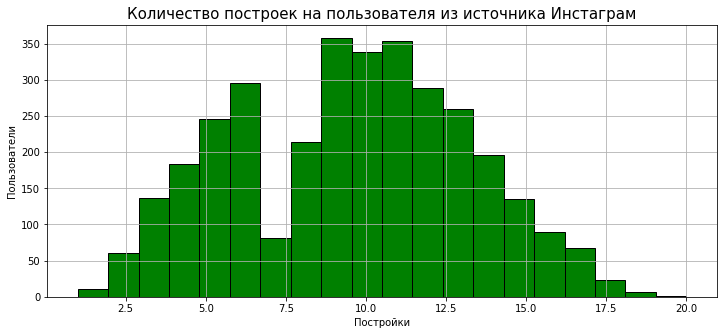

In [43]:
building3(instagram, 'instagram')

In [44]:
def building4(df, name):
    user_build = df.groupby('user_id')['building_type'].count().reset_index()
    user_build.hist(bins=20, figsize=(12,5), color = 'green', ec = 'black');
    plt.title(f'Количество построек на пользователя из источника Фейсбук', fontsize=15);
    plt.xlabel('Постройки', fontsize = 10) 
    plt.ylabel('Пользователи', fontsize = 10);
    print('Среднее количество построек: {:.1f}'.format(user_build['building_type'].sum() / user_build['user_id'].count()))

Среднее количество построек: 9.6


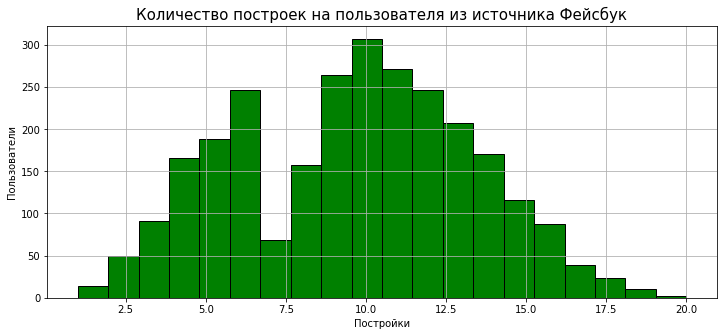

In [45]:
building4(facebook, 'facebook')

In [46]:
def building5(df, name):
    user_build = df.groupby('user_id')['building_type'].count().reset_index()
    user_build.hist(bins=20, figsize=(12,5), color = 'green', ec = 'black');
    plt.title(f'Количество построек на пользователя из источника Ютуб', fontsize=15);
    plt.xlabel('Постройки', fontsize = 10) 
    plt.ylabel('Пользователи', fontsize = 10);
    print('Среднее количество построек: {:.1f}'.format(user_build['building_type'].sum() / user_build['user_id'].count()))

Среднее количество построек: 9.3


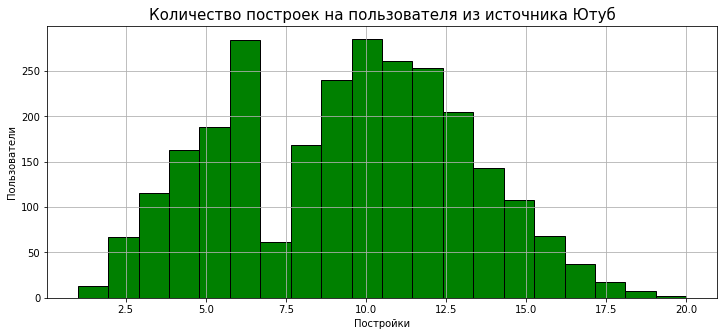

In [47]:
building5(youtube, 'youtube')

In [48]:
def buildings_per_source():
    buildings_per_source = game_actions.groupby('source')['building_type'].count().reset_index()
    plt.figure(figsize=(15,5))
    plt.title('Количество построек в зависимости от канала', fontsize = 15)
    sns.barplot(x = 'source', y = 'building_type', data = buildings_per_source)
    plt.xlabel('Канал', fontsize = 10) 
    plt.ylabel('Постройки', fontsize = 10)

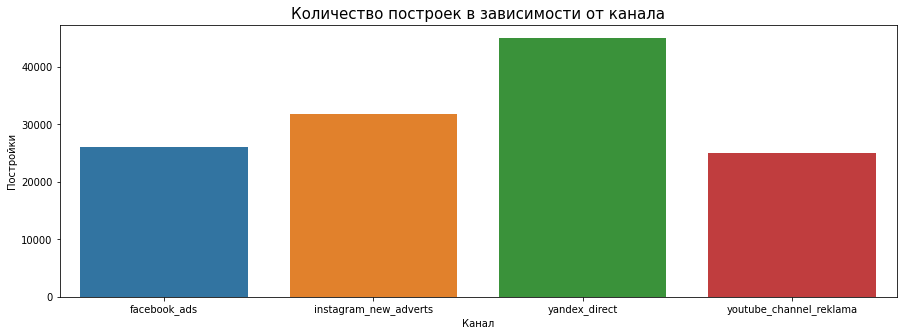

In [49]:
buildings_per_source()

Взглянув на количество построек, мы видим, что большинство из них происходят от пользователей, пришедших из Yandex Direct, затем следуют Instagram и Facebook, а меньше всего построек сделали пользователи, пришедшие через Youtube. Это указывает на то, что Yandex Direct может привлекать более заинтересованных или активных игроков.

## 2.2. Анализ среднего времени, которое пользователи проводят в игре

In [50]:
# выделяем столбцы с пермыи и последним событием пользователя
first_event = game_actions.groupby(['user_id']).agg(first_event_datetime = ('event_datetime', 'min')).reset_index()
last_event = game_actions.groupby(['user_id']).agg(last_event_datetime = ('event_datetime', 'max')).reset_index()

In [51]:
# добавляем столбцы в датафрейм
game_actions = game_actions.merge(first_event, how='left', on='user_id')
game_actions = game_actions.merge(last_event, how='left', on='user_id')

In [52]:
# приводим к нужному типу
game_actions['first_event_datetime'] = game_actions['first_event_datetime'].dt.date
game_actions['last_event_datetime'] = game_actions['last_event_datetime'].dt.date

In [53]:
# добавляем столбец с лайфтаймом пользователя в игре
game_actions['lifetime'] = game_actions['last_event_datetime'] - game_actions['first_event_datetime']

In [54]:
game_actions

,event_datetime,event,building_type,user_id,project_type,source,first_event_datetime,last_event_datetime,lifetime
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama,2020-05-04,2020-05-10,6 days
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads,2020-05-04,2020-05-15,11 days
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts,2020-05-04,2020-05-16,12 days
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,facebook_ads,2020-05-04,2020-05-12,8 days
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,yandex_direct,2020-05-04,2020-05-11,7 days
...,...,...,...,...,...,...,...,...,...
135634,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN,instagram_new_adverts,2020-05-06,2020-06-05,30 days
135635,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN,yandex_direct,2020-05-07,2020-06-05,29 days
135636,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN,youtube_channel_reklama,2020-05-07,2020-06-05,29 days
135637,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN,facebook_ads,2020-05-07,2020-06-05,29 days


In [55]:
print('В среднем пользователи проводят в игре', game_actions['lifetime'].median())

В среднем пользователи проводят в игре 11 days 00:00:00


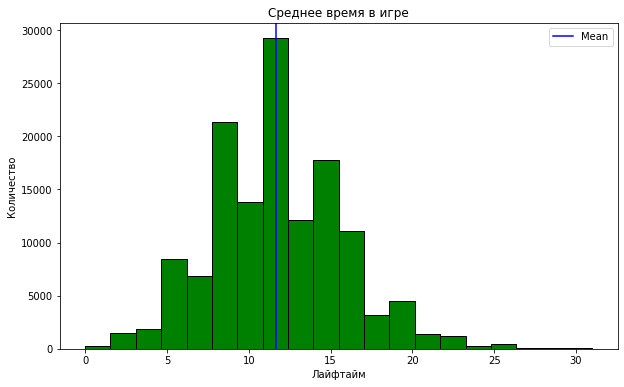

In [56]:
a = game_actions['lifetime'].dt.days
plt.figure(figsize=(10, 6))
plt.hist(a,color = 'green', ec = 'black', bins = 20)
plt.title('Среднее время в игре')
plt.xlabel('Лайфтайм')
plt.ylabel('Количество')
mean_lifetime = a.mean()
plt.axvline(x=mean_lifetime, color='blue', linestyle='-', label='Mean')
plt.legend()
plt.show()

In [57]:
# отделяем игроков, прошедших первый уровень
df_finish_level = game_actions[game_actions['event'] == 'finished_stage_1'].reset_index(drop=True)
id_finish_level = df_finish_level['user_id']

In [58]:
# игроки прошедшие первый уровень
finish_stage = game_actions.query('user_id in @id_finish_level').reset_index(drop=True)
# игроки не прошедшие первый уровень
not_finish_stage = game_actions.query('user_id not in @id_finish_level').reset_index(drop=True)

In [59]:
not_finish_stage

,event_datetime,event,building_type,user_id,project_type,source,first_event_datetime,last_event_datetime,lifetime
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama,2020-05-04,2020-05-10,6 days
1,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,facebook_ads,2020-05-04,2020-05-12,8 days
2,2020-05-04 00:00:36,building,assembly_shop,06c592ca-902d-42bb-bac3-75ce84cca159,NaN,instagram_new_adverts,2020-05-04,2020-05-17,13 days
3,2020-05-04 00:00:38,building,assembly_shop,beb8ca15-33a9-465d-b47b-89aa96f89c9a,NaN,yandex_direct,2020-05-04,2020-05-16,12 days
4,2020-05-04 00:01:59,building,assembly_shop,c99ecd61-1a4e-4bd2-b8b5-1f8bbcd2bdb5,NaN,yandex_direct,2020-05-04,2020-05-26,22 days
...,...,...,...,...,...,...,...,...,...
67165,2020-06-01 16:09:44,building,spaceport,b81fdba1-a168-4c2a-b41d-6a62ca92bec9,NaN,facebook_ads,2020-05-07,2020-06-01,25 days
67166,2020-06-01 21:30:47,building,spaceport,7beb74ff-c5cf-4dfd-a0e6-2685ceddb8ae,NaN,yandex_direct,2020-05-06,2020-06-01,26 days
67167,2020-06-02 08:26:32,building,research_center,70e18c96-221c-4ccc-8b5e-45adc4b7e1a2,NaN,instagram_new_adverts,2020-05-06,2020-06-02,27 days
67168,2020-06-02 21:37:17,building,spaceport,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN,youtube_channel_reklama,2020-05-07,2020-06-05,29 days


In [60]:
# игроки, закончившие уровень через проект 
project_users = finish_stage[finish_stage['event'] == 'project'].reset_index(drop=True)
project_users = project_users['user_id'].unique()

In [61]:
game_user

,user_id,event,count
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,building,0
1,00151b4f-ba38-44a8-a650-d7cf130a0105,building,0
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,building,0
3,001d39dc-366c-4021-9604-6a3b9ff01e25,building,0
4,001d39dc-366c-4021-9604-6a3b9ff01e25,finished_stage_1,0
...,...,...,...
21254,fffb626c-5ab6-47c9-8113-2062a2f18494,finished_stage_1,0
21255,ffff194a-56b7-4c12-860d-3485242ae7f5,building,0
21256,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,building,0
21257,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,finished_stage_1,0


In [62]:
game_user_finish_victory

['001d39dc-366c-4021-9604-6a3b9ff01e25',
 '003ee7e8-6356-4286-a715-62f22a18d2a1',
 '004074f8-251a-4776-922c-8348dca1a2f6',
 '00464e5e-28ed-4be6-bf44-517ef7b3937b',
 '0056c007-c082-43cc-bdef-afc49bca4cb9',
 '005ff87b-b475-4da7-862e-57ab91adbff4',
 '00606a1c-51e1-48d1-b053-77be528527c0',
 '007ad796-add4-41a5-bc2a-e11561f16cd6',
 '007f9ffa-4c39-408b-a2e1-a84ddc10bee1',
 '00ac051d-38ca-4746-b33c-4cff9d298d09',
 '00b45f70-fc28-4af4-9867-487e0a2906e7',
 '00cb37e7-e425-4949-b3df-da316640fd1d',
 '00e92de1-cbe3-41bc-9710-271be7841917',
 '00f1df3e-5f44-4a65-8c40-ce0a4eb9cc11',
 '0108f47c-1f4f-431b-b514-3f9c4120dca7',
 '01097a56-a923-41d0-a625-5057bf3049b5',
 '01303658-5ed3-4b39-85d6-7c7708ed08a6',
 '013cd430-adee-4f9f-a645-e1eef615d9b5',
 '01423f95-1eff-42da-b748-323f488c2a26',
 '014dd0d0-8d73-4ebc-b146-0d518e30cec0',
 '015b90df-f393-4c95-a42c-14917be65000',
 '01672605-47f5-4012-8f06-96f6f621e66c',
 '016a07ce-04c7-4f29-a383-9975b97cfb3c',
 '01802006-dfe4-49a5-9d2f-594099a5e909',
 '01957fa7-5c9e-

In [63]:
# игроки с уровнем, завершившие проект pve
finished_project = finish_stage.query('user_id in @game_user_finish_project').reset_index(drop=True)
# игроки с уровнем, победившие врага pvp
finished_win = finish_stage.query('user_id in @game_user_finish_victory').reset_index(drop=True)

In [64]:
print(finished_project['lifetime'].median(), '- среднее игровое время пользователей, завершивших 1 уровень через проект.')
print(finished_win['lifetime'].median(), '- среднее игровое время пользователей, завершивших 1 уровень через победу над врагом.')


13 days 00:00:00 - среднее игровое время пользователей, завершивших 1 уровень через проект.
11 days 00:00:00 - среднее игровое время пользователей, завершивших 1 уровень через победу над врагом.


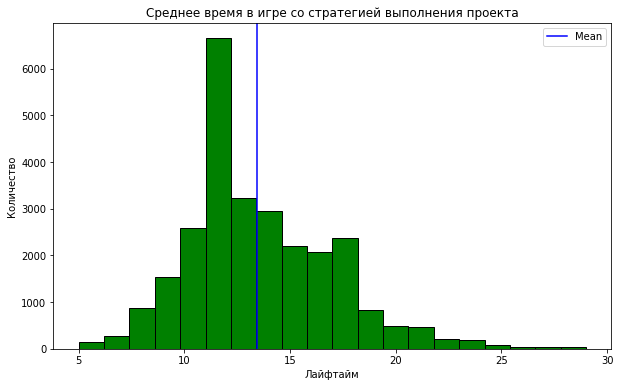

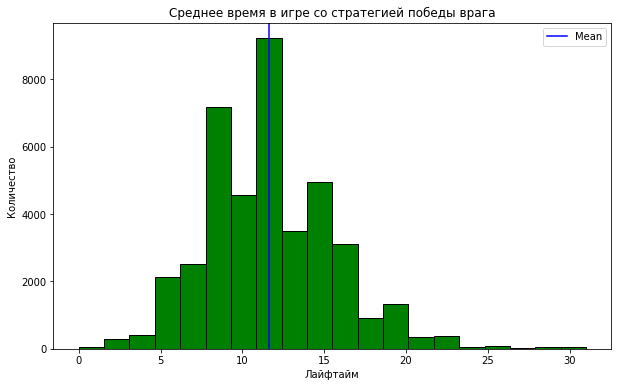

In [65]:
a = finished_project['lifetime'].dt.days
plt.figure(figsize=(10, 6))
plt.hist(a,color = 'green', ec = 'black', bins = 20)
plt.xlabel('Лайфтайм')
plt.title('Среднее время в игре со стратегией выполнения проекта')
plt.ylabel('Количество')
mean_lifetime = a.mean()
plt.axvline(x=mean_lifetime, color='blue', linestyle='-', label='Mean')
plt.legend()
plt.show()

a = finished_win['lifetime'].dt.days
plt.figure(figsize=(10, 6))
plt.hist(a,color = 'green', ec = 'black', bins = 20)
plt.xlabel('Лайфтайм')
plt.title('Среднее время в игре со стратегией победы врага')
plt.ylabel('Количество')
mean_lifetime = a.mean()
plt.axvline(x=mean_lifetime, color='blue', linestyle='-', label='Mean')
plt.legend()
plt.show()

В среднем, стратегия прохождения первого уровня через победу над врагом, оказалась быстрее в реализации на 2 дня, чем стратегия проекта.

## 2.3. Анализ доли пользователей завершивших уровень

In [66]:
id_finish_level

0       ced7b368-818f-48f6-9461-2346de0892c5
1       7ef7fc89-2779-46ea-b328-9e5035b83af5
2       70db22b3-c2f4-43bc-94ea-51c8d2904a29
3       903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b
4       58e077ba-feb1-4556-a5a0-d96bd04efa39
                        ...                 
5812    22cce310-fe10-41a2-941b-9c3d63327fea
5813    d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8
5814    515c1952-99aa-4bca-a7ea-d0449eb5385a
5815    32572adb-900f-4b5d-a453-1eb1e6d88d8b
5816    f21d179f-1c4b-437e-b9c6-ab1976907195
Name: user_id, Length: 5817, dtype: object

In [67]:
def precent_users(df, df2):
    users = df['user_id'].nunique()
    users_2 = df2['user_id'].nunique()
    precent = users_2 / users
    return precent

In [68]:
print('Первый уровень завершили:')
print('{:.1%}'.format(precent_users(game_actions, finish_stage)))
print('Первый уровень не завершили:')
print('{:.1%}'.format(precent_users(game_actions, not_finish_stage)))

Первый уровень завершили:
42.8%
Первый уровень не завершили:
57.2%


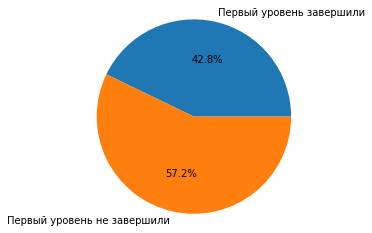

In [69]:
value1 = precent_users(game_actions, finish_stage)
value2 = precent_users(game_actions, not_finish_stage)
values = [value1, value2]
labels = ['Первый уровень завершили', "Первый уровень не завершили"]
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [70]:
finish_stage

,event_datetime,event,building_type,user_id,project_type,source,first_event_datetime,last_event_datetime,lifetime
0,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads,2020-05-04,2020-05-15,11 days
1,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts,2020-05-04,2020-05-16,12 days
2,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,yandex_direct,2020-05-04,2020-05-11,7 days
3,2020-05-04 00:00:36,building,assembly_shop,4fe0f101-694b-4e31-9740-d1d87f7208ea,NaN,facebook_ads,2020-05-04,2020-05-16,12 days
4,2020-05-04 00:00:44,building,assembly_shop,65a92713-5969-48b1-8945-bfefa5063887,NaN,yandex_direct,2020-05-04,2020-05-18,14 days
...,...,...,...,...,...,...,...,...,...
68464,2020-06-04 18:14:33,building,research_center,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN,yandex_direct,2020-05-07,2020-06-05,29 days
68465,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN,instagram_new_adverts,2020-05-06,2020-06-05,30 days
68466,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN,yandex_direct,2020-05-07,2020-06-05,29 days
68467,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN,facebook_ads,2020-05-07,2020-06-05,29 days


In [71]:
# Код ревьюера
v1 = game_actions[game_actions["event"] == "finished_stage_1"].groupby('source')["user_id"].count()
v2 = game_actions.groupby('source')["user_id"].nunique()
v1 / v2

source
facebook_ads               0.421864
instagram_new_adverts      0.438004
yandex_direct              0.423915
youtube_channel_reklama    0.431497
Name: user_id, dtype: float64

Анализ этого значения показывает нам, что игроки из канала Инстаграм и Ютуб завершают первый уровень немного  чаще других. Далее идут игроки привлеченные Яндекс директ и Фейсбук.

## 2.4. Анализ долей различных стратегий в канале 

In [72]:
print('Закончили первый уровень проектом:')
print('{:.1%}'.format(precent_users(finish_stage, finished_project)))
print('Закончили первый уровень победой:')
print('{:.1%}'.format(precent_users(finish_stage, finished_win)))

Закончили первый уровень проектом:
32.1%
Закончили первый уровень победой:
67.9%


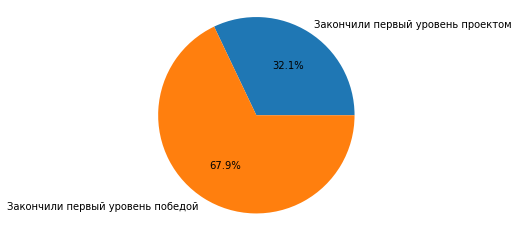

In [73]:
value1 = precent_users(finish_stage, finished_project)
value2 = precent_users(finish_stage, finished_win)
values = [value1, value2]
labels = ['Закончили первый уровень проектом', "Закончили первый уровень победой"]
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [74]:
game_actions_unique = game_actions.drop_duplicates(subset='user_id')
game_actions_unique

,event_datetime,event,building_type,user_id,project_type,source,first_event_datetime,last_event_datetime,lifetime
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama,2020-05-04,2020-05-10,6 days
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads,2020-05-04,2020-05-15,11 days
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts,2020-05-04,2020-05-16,12 days
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,facebook_ads,2020-05-04,2020-05-12,8 days
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,yandex_direct,2020-05-04,2020-05-11,7 days
...,...,...,...,...,...,...,...,...,...
78142,2020-05-10 23:34:33,building,assembly_shop,20bc9d79-10c4-4f2d-862e-4a6dece3b4ec,NaN,youtube_channel_reklama,2020-05-10,2020-05-31,21 days
78144,2020-05-10 23:34:43,building,assembly_shop,daea0325-f7c5-4008-b5f6-f89fc2c1e019,NaN,yandex_direct,2020-05-10,2020-05-10,0 days
78234,2020-05-10 23:44:17,building,assembly_shop,7b225969-375a-455e-a14a-ed1ab373fb65,NaN,instagram_new_adverts,2020-05-10,2020-05-24,14 days
78385,2020-05-10 23:57:56,building,assembly_shop,cafd1b8b-507b-49ae-abf0-89fe863a8b03,NaN,facebook_ads,2020-05-10,2020-05-18,8 days


<AxesSubplot:title={'center':'Среднее время завершения уровня в зависимости от канала'}, xlabel='source', ylabel='lifetime_days'>

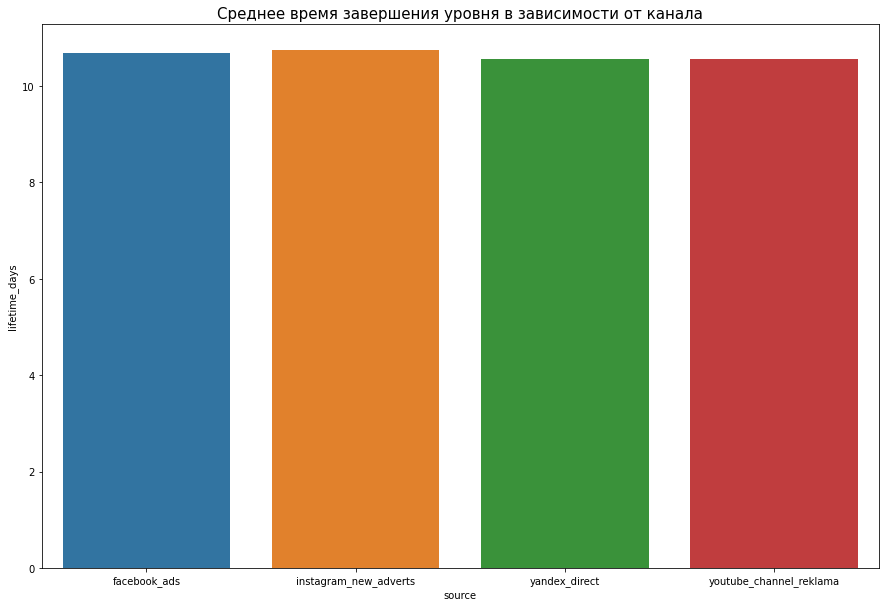

In [75]:
game_actions_unique['lifetime_days'] = game_actions_unique['lifetime'].dt.days
average_lifetime_per_source = game_actions_unique.groupby('source')['lifetime_days'].mean().reset_index()
plt.figure(figsize=(15, 10))
plt.title(f'Среднее время завершения уровня в зависимости от канала', fontsize=15)
sns.barplot(data = average_lifetime_per_source, x = 'source', y = 'lifetime_days')

2/3 игроков, которые завершили первый уровень, выбрали стратегию сражения и победы над врагом.

## 3. Вычисление метрики САС

CAC показывает, в какую сумму компании обходится каждый новый клиент. Это мы сейчас и посчитаем.

In [76]:
ad_costs

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796
5,facebook_ads,2020-05-08,68.009276
6,facebook_ads,2020-05-09,38.723350
7,instagram_new_adverts,2020-05-03,943.204717
8,instagram_new_adverts,2020-05-04,502.925451
9,instagram_new_adverts,2020-05-05,313.970984


In [77]:
# всего за период с 2020-05-03 по 2020-05-09 потрачено
total_cost = ad_costs['cost'].sum()
print('Всего за период с 2020-05-03 по 2020-05-09 потрачено, total_cost, у.е.')

Всего за период с 2020-05-03 по 2020-05-09 потрачено, total_cost, у.е.


In [78]:
start_date = pd.to_datetime('2020-05-03')
end_date = pd.to_datetime('2020-05-09')
filtered_game_actions_unique = game_actions_unique[(game_actions_unique['first_event_datetime'] >= start_date) & (game_actions_unique['first_event_datetime'] <= end_date)]
filtered_game_actions_unique

,event_datetime,event,building_type,user_id,project_type,source,first_event_datetime,last_event_datetime,lifetime,lifetime_days
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama,2020-05-04,2020-05-10,6 days,6
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads,2020-05-04,2020-05-15,11 days,11
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts,2020-05-04,2020-05-16,12 days,12
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,facebook_ads,2020-05-04,2020-05-12,8 days,8
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,yandex_direct,2020-05-04,2020-05-11,7 days,7
...,...,...,...,...,...,...,...,...,...,...
63108,2020-05-09 23:50:21,building,assembly_shop,117ce7a1-41e5-41b1-bedf-7e12940a2c34,NaN,youtube_channel_reklama,2020-05-09,2020-05-19,10 days,10
63112,2020-05-09 23:50:42,building,assembly_shop,7598633d-2111-4a2c-ada1-a6dcc25b7b9a,NaN,yandex_direct,2020-05-09,2020-05-11,2 days,2
63139,2020-05-09 23:54:15,building,assembly_shop,9aa4655a-2fe4-40e0-9976-7686d2d6e489,NaN,instagram_new_adverts,2020-05-09,2020-05-15,6 days,6
63143,2020-05-09 23:54:23,building,assembly_shop,afa1f9b4-818d-4c77-b9b1-4019d516292c,NaN,instagram_new_adverts,2020-05-09,2020-05-12,3 days,3


In [79]:
CAC = total_cost/filtered_game_actions_unique.shape[0]
print('Средняя стоимость привлечение одного клиента равноа', CAC, 'у.е.')

Средняя стоимость привлечение одного клиента равноа 0.571482674692824 у.е.


In [80]:
# разбивка по каналам
sum_add = ad_costs.groupby('source')['cost'].sum().sort_values(ascending=False).reset_index()

In [81]:
users_count = user_source.groupby('source')['user_id'].count().sort_values(ascending=False).reset_index()

In [82]:
sum_add['mean_cost'] = (sum_add['cost'] / users_count['user_id'])

In [83]:
sum_add

,source,cost,mean_cost
0,yandex_direct,2233.111449,0.463590
1,instagram_new_adverts,2161.441691,0.645785
2,facebook_ads,2140.904643,0.785365
3,youtube_channel_reklama,1068.119204,0.397662


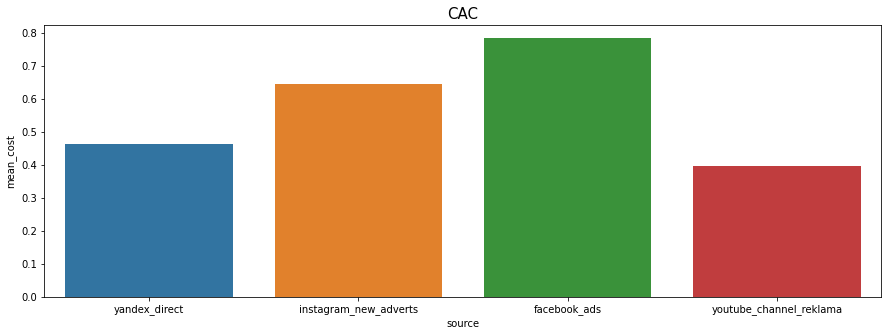

In [84]:
plt.figure(figsize=(15, 5))
plt.title('CAC', fontsize=15)
sns.barplot(x = 'source', y = 'mean_cost', data = sum_add);

Наибольшее количество пользователей приходит из источника Яндекс Директ, из источников Инстаграм и Фейсбук почти одинаковое приблизительно 2100. Реклама из источника Ютуб самая малочисленная. 
По стоимости одного пользователя дешевле всего обходятся каналы привлечения Ютуб и Яндекс. Самый дорогой источник - Фейсбук.

## 4.1. Проверка 1 гипотезы

H0: среднее время завершения уровня не различается в зависимости способа прохождения.

H1: среднее время завершения уровня различается в зависимости способа прохождения.

In [85]:
#Код 
print("1)")
A = [1]
B = [1]
print("A", "B", "A+B", "len(A+B)", sep="\t")
print(A, B, A+B, len(A+B), sep="\t")

print("\n2)")

A = np.array([1])
B = np.array([1])
print("A", "B", "A+B", "len(A+B)", sep="\t")
print(A, B, A+B, len(A+B), sep="\t")


print("\n3)")
C = pd.Series([1, 2, 3, 4, 5])
A = C[:3]
B = C[2:]
print("A:", A, "\nB:", B, "\nA+B:", A+B, "\nlen(A+B):", len(A+B), sep="\n")


1)
A	B	A+B	len(A+B)
[1]	[1]	[1, 1]	2

2)
A	B	A+B	len(A+B)
[1]	[1]	[2]	1

3)
A:
0    1
1    2
2    3
dtype: int64

B:
2    3
3    4
4    5
dtype: int64

A+B:
0    NaN
1    NaN
2    6.0
3    NaN
4    NaN
dtype: float64

len(A+B):
5


In [86]:
#Код 
# print(f"Суммарная мощность выборок: {len(finished_project['lifetime']) + len(finished_win['lifetime'])}")

In [87]:
len(finished_project['user_id'].unique())

1866

In [88]:
#print(f"Суммарная мощность выборок: {len(game_user_finish_project) + len(game_user_finish_victory)}")

In [89]:
finished_project = finished_project.drop_duplicates(subset='user_id')
finished_project.head()

,event_datetime,event,building_type,user_id,project_type,source,first_event_datetime,last_event_datetime,lifetime
0,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads,2020-05-04,2020-05-15,11 days
1,2020-05-04 00:00:44,building,assembly_shop,65a92713-5969-48b1-8945-bfefa5063887,NaN,yandex_direct,2020-05-04,2020-05-18,14 days
2,2020-05-04 00:01:33,building,assembly_shop,fa352362-d258-472c-b295-2796ccc39fa3,NaN,youtube_channel_reklama,2020-05-04,2020-05-19,15 days
3,2020-05-04 00:02:56,building,assembly_shop,7b3b6554-7949-4065-9808-d6c79bdc2f58,NaN,instagram_new_adverts,2020-05-04,2020-05-15,11 days
4,2020-05-04 00:03:46,building,assembly_shop,b374304d-2f74-4cc1-a4e2-500da44a06c7,NaN,facebook_ads,2020-05-04,2020-05-15,11 days


In [90]:
finished_win = finished_win.drop_duplicates(subset='user_id')
finished_win.head()

,event_datetime,event,building_type,user_id,project_type,source,first_event_datetime,last_event_datetime,lifetime
0,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts,2020-05-04,2020-05-16,12 days
1,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,yandex_direct,2020-05-04,2020-05-11,7 days
2,2020-05-04 00:00:36,building,assembly_shop,4fe0f101-694b-4e31-9740-d1d87f7208ea,NaN,facebook_ads,2020-05-04,2020-05-16,12 days
3,2020-05-04 00:02:24,building,assembly_shop,9c200ece-3b74-44c4-8a3f-260f2486c5d7,NaN,facebook_ads,2020-05-04,2020-05-12,8 days
4,2020-05-04 00:03:10,building,assembly_shop,02bf92c2-17a0-4156-be88-2054fb6b7421,NaN,yandex_direct,2020-05-04,2020-05-11,7 days


In [91]:
print(f"Суммарная мощность выборок: {len(finished_project) + len(finished_win)}")

Суммарная мощность выборок: 5817


In [92]:
finished_project['lifetime'] = finished_project['lifetime'].dt.days
finished_win['lifetime'] = finished_win['lifetime'].dt.days
t_statistic, p_value = st.ttest_ind(finished_project['lifetime'], finished_win['lifetime'])
print("T-статистика:", t_statistic)
print("p-значение:", p_value)

T-статистика: 21.19347568064039
p-значение: 4.363370007994992e-96


Время завершения уровня различается в зависимости способа прохождения.
Получли значение t-test 61, то есть отклоняется на 21 среднекквадратичное отклонение, что много на самом деле, а p-value равное 4, показывает, вероятность отклониться.

Нулевая гипотеза отвергается, альтернативную гипотезу отвергнуть не удалось.

## 4.2. Проверка 2 гипотезы

H0: Среднее время в игре пользователей из источника instagram_new_adverts равно среднему времени в игре пользователей из источника youtube_channel_reklama.

H1: Среднее время в игре пользователей из источника instagram_new_adverts отличается от среднего времени в игре пользователей из источника youtube_channel_reklama.

In [93]:
game_actions_unique = game_actions.drop_duplicates(subset='user_id')
source_X_data = game_actions_unique[game_actions_unique['source'] == 'instagram_new_adverts']['lifetime'].dt.days
source_Y_data = game_actions_unique[game_actions_unique['source'] == 'youtube_channel_reklama']['lifetime'].dt.days
t_stat, p_value = ttest_ind(source_X_data, source_Y_data, equal_var=False)
print('T-статистика:', t_stat)
print('P-значение:', p_value)

T-статистика: 1.6858508909796104
P-значение: 0.0918791932701945


T-test = 1.6858508909796104 и p-value = 0.0918791932701945, есть небольшое отклонение среднего времени в игре между пользователяит из instagram_new_adverts и youtube_channel_reklama, но оно небольшое, также наше значение p-value > 0.05 (обычный порог для подтверждения нулевой гипотезы), значит среднее время в игре пользователей из источника instagram_new_adverts равно среднему времени в игре пользователей из источника youtube_channel_reklama.

Нулевую гипотезу отвергнуть не удалось, альтернативная отвергается

## ВЫВОДЫ

Анализ данных завершен. Была проведена обработка: удалены дубликаты, типы данных приведены к нужным форматам. 
В ходе работы удалось выяснить, что первый уровень закончили 42.8%. 57,2% игроков бросили играть.  Возможно стоит приложить усилия и придумать, как удерживать пользователей и мотивировать играть дальше.

В игре есть 2 стратегии прохождения уровня - победа через проект или победа врага. 2/3 игроков, которые завершили первый уровень, выбрали стратегию сражения и победы над врагом, проведя в игред в среднем 11 дней до получения первого уровня. Игроки выбравшие стратегию выполнения проекта, в игре провели в среднем 11 дней. 

Прохождение проекта подразумевает постройку объектов. Среднее число построек равно 9. На отметке 7-8 построек наблюдается спад, это может быть связано с тем, что на этой отметке пользователи переходят на новый уровень победив врага или продолжают постройку сданий дальше. Возможно, здесь так же есть игроки, которые еще в процессе прохождения уровня.

Пользователи привлекаются из 4 каналов: Ютуб, Фейсбук, Яндекс и Инстаграм. Наибольший поток  приходит из источника Яндекс Директ (), из источников Инстаграм и Фейсбук почти одинаковое приблизительно 2100. Реклама из источника Ютуб самая малочисленная. 
По стоимости одного пользователя дешевле всего обходятся каналы привлечения Ютуб и Яндекс. Наименьшие затраты на привлечение игроков у Ютуб — 0,4 у.е. Это вдвое меньше наиболее дорогого показателя у Фейсбук — 0,79 у.е.

На проверку были выдвинуты 2 гипотезы о равенсве/различии времени в зависимости способа прохождения и о равенстве/различии среднего время в игре пользователей из источника instagram_new_adverts и среднего времени в игре пользователей из источника youtube_channel_reklama.

В первом случае, время завершения уровня различается в зависимости способа прохождения.

Во втором, среднее время в игре пользователей из источника instagram_new_adverts равно среднему времени в игре пользователей из источника youtube_channel_reklama. 

Наибольшее количество пользователей приходит из источника Яндекс Директ, из источников Инстаграм и Фейсбук почти одинаковое, приблизительно 2100. Реклама из источника Ютуб самая малочисленная.

В контексте стоимости привлечения одного пользователя, каналы Ютуб и Яндекс оказываются наиболее экономичными. Наиболее дорогой источник - Фейсбук, в то время как Яндекс и Ютуб показывают наименьшую стоимость привлечения одного пользователя, 0.46 и 0.40 у.е. соответственно. Это говорит о том, что именно эти источники являются наиболее эффективными в плане бюджета на рекламу.

Однако, когда мы рассматриваем продолжительность жизни пользователей, то есть время, в течение которого они остаются активными в игре, мы видим, что все источники в целом демонстрируют схожие результаты, около 10.5 - 10.7 дней.

Интересно, что, несмотря на то что Ютуб привлекает меньшее количество пользователей и имеет наименьшую стоимость привлечения, пользователи из этого источника проводят в игре примерно столько же времени, сколько и пользователи из других источников. Таким образом, Ютуб может оказаться очень эффективным каналом с точки зрения соотношения стоимости и вовлеченности пользователей.

Игроки из каналов Инвстаграм и Ютуб чаще немного чаще доходят до первого уровня, чем игроки из источникоа Фейсбук и Яндекс.

Особых различий в поведении пользователей по каналам выявить не удалось.

Получается, что в инстаграм стоимость пользователя (сас) достаточно высокая, возможно, стоит направить средства на рекламу в источниках Яндекс и Ютуб, ведь они привлекают такое же количество игроков, но это получается дешевле. Фейсбук и инстаграм выходят немного дороже, но плохими источниками пользователей их назвать нельзя. С ними тоже  можно работать. Для оптимизации средств, возможно, стоит распределить рекламный бюджет немного иначе.
